# SMALL-FOOTPRINT KEYWORD SPOTTING
## *1.DATA ANALYSIS AND PREPROCESSING*

In this notebook, we show how to load the files and do some exploratory analysis. Additionally, we extract the features that will be used in the next notebook.

#### Import basic libraries

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io import wavfile
from scipy.fftpack import dct
from IPython import display
from python_speech_features import mfcc, logfbank, ssc

import pywt
import librosa
import soundfile

2024-03-08 12:59:07.608890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 12:59:07.615000: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 12:59:07.638422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 12:59:07.638448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 12:59:07.639068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Useful Functions

In [3]:
def get_files(path):
    """
    Extract audio files from a folder

    Args:
        path: direction of the folder

    Return:
        saved: all the samples of the folders
        list_folders: labels of the folders
    """

    list_folders = sorted(os.listdir(path))
    saved = [0]*len(list_folders)

    for idx, audios in enumerate(list_folders):
        saved[idx] = os.listdir(os.path.join(path, audios))

    return(saved, list_folders)

In [4]:
def slicer(wave):
    """
    Slice the original wave removing the silence

    Args:
        wave: an audio sample

    Return:
        A shorter wave without silence
    """

    threshold = np.mean(abs(wave))
    for i in range(wave.shape[0]):
        if wave[i] > threshold:
            wave = wave[i:]
            break
    
    return wave

def slice_audio_folder_creator(audio_samples, audio_labels, folder_new, folder_old):
    """
    Remove the silence of each file

    Args:
        audio_samples: audio samples
        audio_labels: labels of the folder
        folder_new: direction of the new folder
        folder_old: direction of the old folder

    Return:
        A new folder with the same labels and file's names but with 
        shorter audio files removing the silence of each one.
    """

    for i in range(len(audio_labels)):
        dir = os.path.join(folder_new, audio_labels[i])
        dir_old = os.path.join(folder_old, audio_labels[i])
        for smpl in audio_samples[i]:
            audio, sr = librosa.load(os.path.join(dir_old, smpl))
            soundfile.write(os.path.join(dir, smpl), slicer(slicer(audio)[::-1])[::-1] ,sr)
    
    return (print("Done"))

In [5]:
def combine_audio(phrase_path, label, noise="exercise_bike", apply_noise=True, noise_volume_scale=0.2, *args):
    """
    Combine a noise file with a word-audio file

    Args:
        phrase_path: the path where the audio file is
        label: label of each folder
        noise: type of noise you want to use. It can be choosen between,
            doing_the_dishes, dude_miaowing, exercise_bike, pink_noise, running_tap, white_noise
        apply_noise: if apply or not a noise 
        noise_volume_scale: controls the noise volume
    
    Return:
        waveform: a wave superposed with noise. The noise was taken from the 
            "background_noise" folder and reduced by a factor of 0.2.
    """

    phrase_audio, sample_rate= tf.audio.decode_wav(tf.io.read_file(phrase_path), desired_channels=1)
    phrase_audio = tf.squeeze(phrase_audio, axis = -1)
    desired_length = 16000
    padding_length = desired_length - tf.shape(phrase_audio)[0]
    padding = tf.zeros(padding_length, dtype=tf.float32)
    
    if padding_length % 2 == 0:
        padding1 = padding2 = padding[:padding_length // 2]
    else:
        padding1 = padding[:padding_length // 2]
        padding2 = padding[(padding_length // 2):]
        
    phrase_audio = tf.concat([padding1, phrase_audio, padding2], 0)


    if apply_noise: 
        
        noise_dict = {"doing_the_dishes": 0, "dude_miaowing": 1, "exercise_bike": 2, "pink_noise": 3, "running_tap": 4, "white_noise": 5}
        noise_path = "./_background_noise_"
        noise_opts = os.listdir(noise_path)

        # Load audio files
        noise_audio, _ = tf.audio.decode_wav(tf.io.read_file(os.path.join(noise_path, noise_opts[noise_dict.get(noise)])), desired_channels=1)
        noise_audio = tf.squeeze(noise_audio, axis = -1)

        start_position = tf.random.uniform([], maxval=len(noise_audio) - len(phrase_audio), dtype=tf.int32)

        noise_audio = noise_audio[start_position:start_position+len(phrase_audio)] * noise_volume_scale 
        phrase_audio = phrase_audio + noise_audio


    #phrase_audio = tf.squeeze(phrase_audio, axis = -1)
    #sample_rate = tf.cast(sample_rate, dtype = tf.int64)
    #phrase_audio = tfio.audio.resample(phrase_audio, rate_in= sample_rate, rate_out = 16000)


    # Export the combined audio to a new file
    return phrase_audio, label, phrase_path

In [6]:
def tensorflow_creator(audio_samples, audio_labels, folder):
    """
    Convert data into tensorflow datasets

    Args:
        audio_samples: samples of the audio
        audio_labels: labels of the audio
        folder: general folder where all the label folders are

    Return:
        Tensorflow dataset
    """
    datasets = []

    for labels_idx, labels in enumerate(audio_labels):
        label_audio_s = os.path.join(folder, labels)
        label_audio = tf.data.Dataset.list_files(label_audio_s + "/*.wav")
        label_audio = tf.data.Dataset.zip((label_audio, tf.data.Dataset.from_tensor_slices(labels_idx*tf.ones(len(label_audio), dtype=tf.dtypes.int32))))
        datasets.append(label_audio)
    
    return datasets


def concatenate_tensorflow(data):
    """
    Concatenate tensorflow datasets

    Args:
        data: tensorflow dataset, the output of 'tensorflow_creator' function
    
    Return:
        Tensorflow dataset with audios of all labels
    """
    concatenated_data = data[0]
    for i in range (1, len(data)):
        concatenated_data = data[i].concatenate(concatenated_data)
    return concatenated_data


def reshape_tf(float_tensor, int_tensor, size_1, size_2):
    """
    Reshape float and int tensorflow datasets 

    Args:
        float_tensor: float tensorflow dataset 
        int_tensor: int tensorflow dataset 
        size_1: size required for float_tensor
        size_2: size required for int_tensor

    Return:
        float_tensor: float tensorflow dataset with differet shape
        int_tensor: int tensorflow dataset with different shape
    """
    # Reshape or preprocess the float tensor to the expected shape
    # Example: Padding or truncating sequences
    float_tensor = tf.reshape(float_tensor, size_1)
    int_tensor = tf.reshape(int_tensor, size_2)

    return float_tensor, int_tensor

In [7]:
def stft(wav, label):
    """
    Convert waveforms to spectrograms using short-time Fourier transform

    Args:
        wav: audio file
        label: labels of the audios

    Return:
        Spectrogram using short-time Fourier transform
    """
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step = 32, window_fn=tf.signal.hamming_window)
    spectrogram = tf.abs(spectrogram)

    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns)
    # Add an epsilon to avoid taking a log of zero
    spectrogram = tf.math.log(tf.transpose(spectrogram))

    return spectrogram, label

In [8]:
def filter_banks(file_path, label):
    """
    Convert waveforms to spectrograms using Mel filterbanks transform

    Args:
        file_path: the path where the audio file is
        label: labels of the audios

    Return:
        Spectrogram using Mel filterbanks transform
    """

    # Parameters
    sample_rate = 16000
    pre_emphasis = 0.97
    frame_size = 0.025
    frame_stride = 0.01
    NFFT = 512
    nfilt = 40

    #Apply Pre-Emphasis for aplifying the high frequencies
    emphasized_signal = np.append(file_path[0], file_path[1:] - pre_emphasis*file_path[-1])

    # Split singla into short-time frames
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]    
    frames *= np.hamming(frame_length)

    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)

    return filter_banks, label

In [9]:
def MFCC(signal, label, phrase_audio, 
            samplerate=16000, winlen=0.025, winstep=0.01, 
            numcep=13, nfilt=26, nfft=512, lowfreq=0, 
            highfreq=8000, preemph=0.97, ceplifter=22, 
            appendeEnergy=False, winfunc= np.hamming):
    """
    Compute MFCC features from an audio signal.

    Args:	
        signal: the audio signal from which to compute features. Should be an N*1 array
        label: labels of the audios
        samplerate: the samplerate of the signal we are working with.
        winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
        winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
        numcep: the number of cepstrum to return, default 13
        nfilt: the number of filters in the filterbank, default 26.
        nfft: the FFT size. Default is 512.
        lowfreq: lowest band edge of mel filters. In Hz, default is 0.
        highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
        preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
        ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
        appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
        winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    
    Returns:	
        A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    mfcc_feat = mfcc(signal, 
                    samplerate, 
                    winlen, 
                    winstep, 
                    numcep, 
                    nfilt, 
                    nfft, 
                    lowfreq, 
                    highfreq, 
                    preemph, 
                    ceplifter, 
                    appendeEnergy, 
                    winfunc)
    
    mfcc_spectrogram = tf.convert_to_tensor(mfcc_feat, dtype=tf.float32)

    mfcc_spectrogram = tf.reshape(mfcc_spectrogram, [99, 13])
    
    return mfcc_spectrogram, label, phrase_audio
    

In [10]:
def DWT(waveform, label, noise, apply_noise, noise_volume_scale):
  """
    Convert waveforms to spectrograms using Discrete Wavelet Transform

    Args:
        waveform: audio file
        label: labels of the audios
        noise: select the noise 
        apply_noise: True or False

    Return:
        Spectrogram using Discrete Wavelet Transform
    """

  # Convert the waveform to a spectrogram via a STFT.
  wavelet = 'db1'
  level = 4


  waveform, _, _ = combine_audio(waveform, label)
  waveform = waveform[:15996]
  #zero_padding = tf.zeros([15996]- tf.shape(waveform), dtype = tf.float32)
  #waveform = tf.concat([zero_padding, waveform], 0)

  # Apply DWT
  coeffs = pywt.wavedec(waveform.numpy(), wavelet, level=level)
  spectrogram = pywt.waverec(coeffs, wavelet)
  spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)

  spectrogram = spectrogram[:15996]
  #spectrogram = tf.math.log(tf.transpose(spectrogram))
  spectrogram = tf.reshape(spectrogram, [124, 129])

  return spectrogram, label

## 1. Data loading and visualization

In the present project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) which contains small-footprint keywords (one-second long) audio clips of English commands on WAV format. The used version, 0.02, contains 105.829 utteraces of 35 different words among which are words like "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", etc. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google.

### 1.1. Download data

In [11]:
DATASET_PATH = 'speech_commands_v0.02'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='dataset')

### 1.2. Dataset organization

In [12]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md')                   & 
                    (commands != '.DS_Store')                   & 
                    (commands != 'testing_list.txt')            & 
                    (commands != 'validation_list.txt')         & 
                    (commands != 'training_list.txt')           &
                    (commands != 'LICENSE')                     &
                    (commands != 'full_speech_commands.zip')    &
                    (commands != '_background_noise_')]

commands = sorted(commands)
print('Commands:', commands)
print('\nNumber of commands: ', len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands:  35


### 1.3. Load Data

We use **get_files** function to obtain the paths corresponding to each audio. Once the directories are specified, we use the `wavfile.read` function from scipy library for reading all the .wav files. The output returns a tuple of two items: the first is the sampling rate, the second is a numpy array with all the data read from the file that we use for plotting random examples.

We can change the labels that we want to plot just changing the arguments of variable *n_folder*. In this case, the plots are 5 is *down*, 22 is *right* and 30 is *up*. While the audio file is choosen randonmly.

In [13]:
data_folder = "./dataset"
audio_samples, audio_labels = get_files(data_folder)

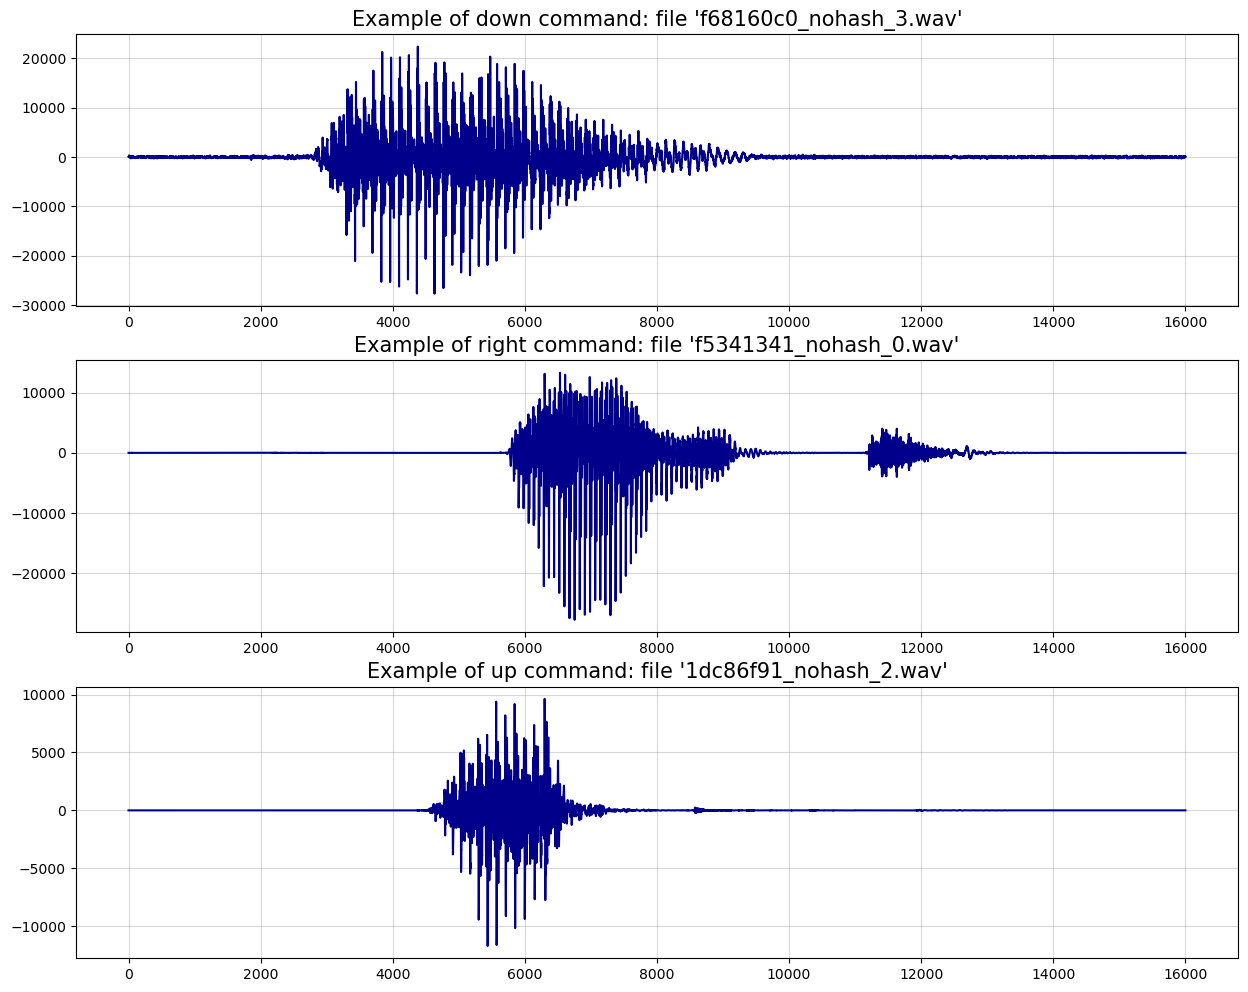

In [14]:
n_folder = [5, 22, 30]
fig, ax = plt.subplots(len(n_folder), figsize=(15,12))

for idx, n_f in enumerate(n_folder):
    n_file = np.random.randint(0, 1000)
    _, data = wavfile.read(os.path.join(data_folder, audio_labels[n_f], audio_samples[n_f][n_file]))

    ax[idx].plot(data, color='darkblue')
    ax[idx].grid(alpha=0.5)
    ax[idx].set_title("Example of {} command: file '{}'".format(audio_labels[n_f], audio_samples[n_f][n_file]), fontsize=15)
    #display.display(display.Audio(data, rate=16000))

### 1.4. Preprocessing

We start the preprocessing part analyzig the length of the audio files using a histogram as follow.

Text(0.5, 0, 'Audio length')

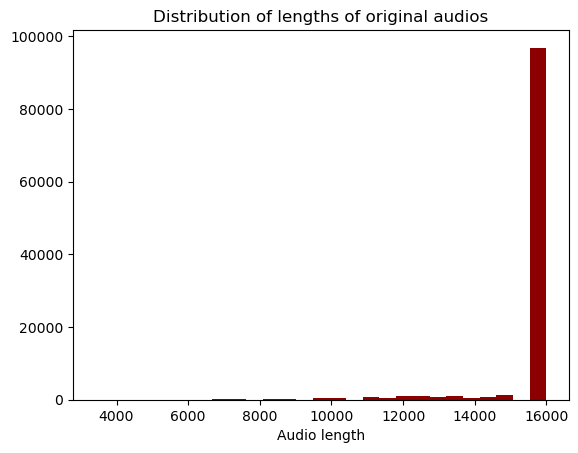

In [15]:
audio_len_array = []

for i in range(0, len(audio_labels)):
    for j in range(0, len(audio_samples[i])):
        _, data = wavfile.read(os.path.join(data_folder, audio_labels[i], audio_samples[i][j]))
        audio_len_array.append(len(data))

plt.hist(audio_len_array, bins="doane", color="darkred")
plt.title("Distribution of lengths of original audios")
plt.xlabel("Audio length")

When we observe the previous plots, we can realize some interesting characteristics. The first, audio files have different lenghts although the most have 16000. The second, there are silence periods considerably large with respect to the keyword itself. This silence could be slow the training part, reason why we decide to delete the silence and just work with the part of the keyword. 

In order to delete the silence, **slice_audio_folder_creator** function is used, creating a new folder called `sliced_dataset` which have the same names but smaller audio file lengths. As before, we use `wavfile.read` function to plot them. And again a histogram is used to analyze the distribution of lengths of the audios.

In [16]:
#slice_audio_folder_creator(audio_samples, audio_labels, "sliced_dataset", "dataset")

In [17]:
data_folder = "./sliced_dataset"
audio_samples, audio_labels = get_files(data_folder)

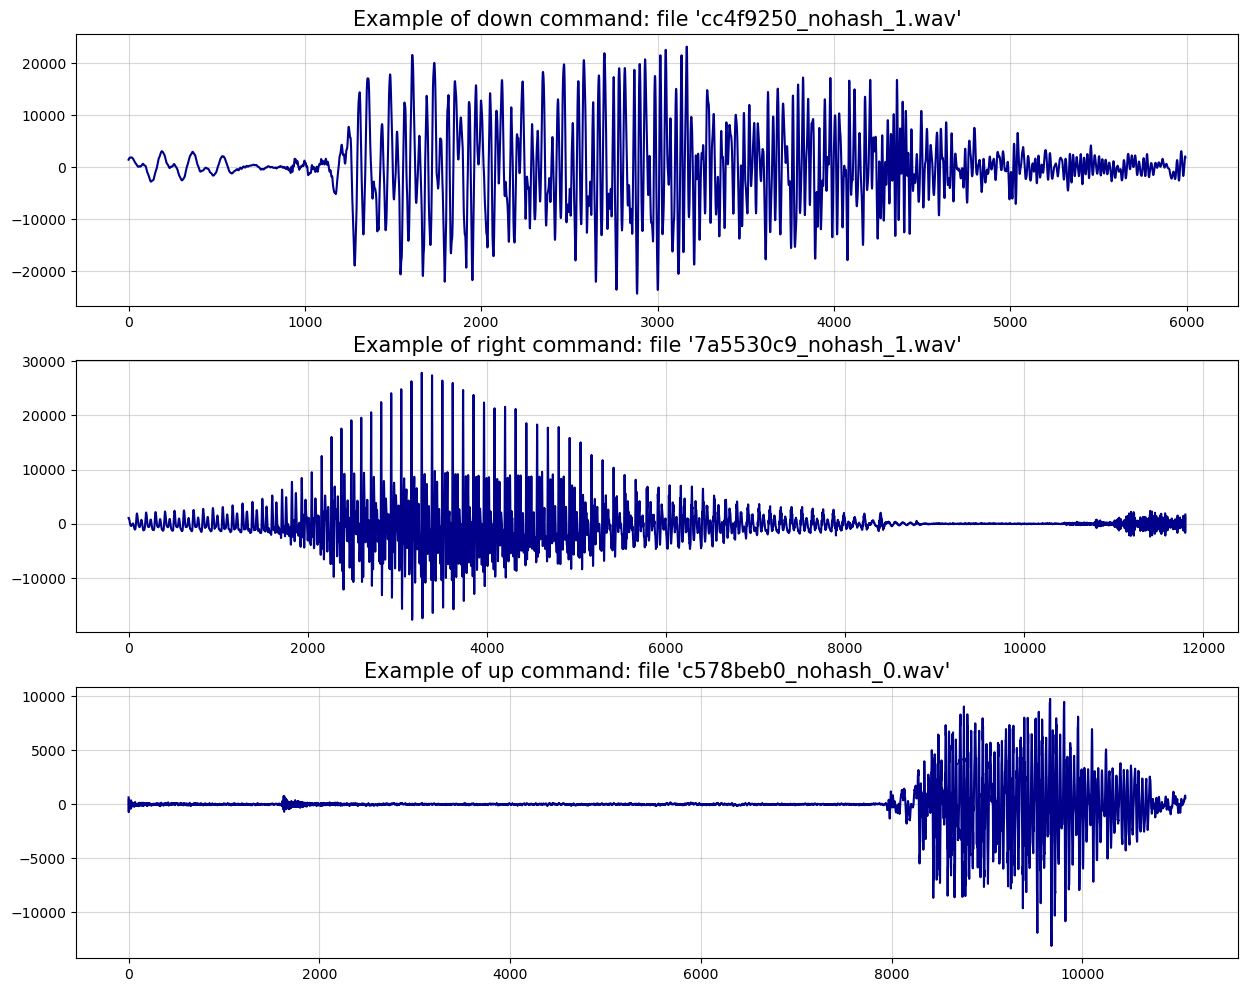

In [18]:
n_folder = [5, 22, 30]
fig, ax = plt.subplots(len(n_folder), figsize=(15,12))

for idx, n_f in enumerate(n_folder):
    n_file = np.random.randint(0, 1000)
    _, data = wavfile.read(os.path.join(data_folder, audio_labels[n_f], audio_samples[n_f][n_file]))

    ax[idx].plot(data, color='darkblue')
    ax[idx].grid(alpha=0.5)
    ax[idx].set_title("Example of {} command: file '{}'".format(audio_labels[n_f], audio_samples[n_f][n_file]), fontsize=15)
    #display.display(display.Audio(data, rate=16000))

Text(0.5, 0, 'Audio length')

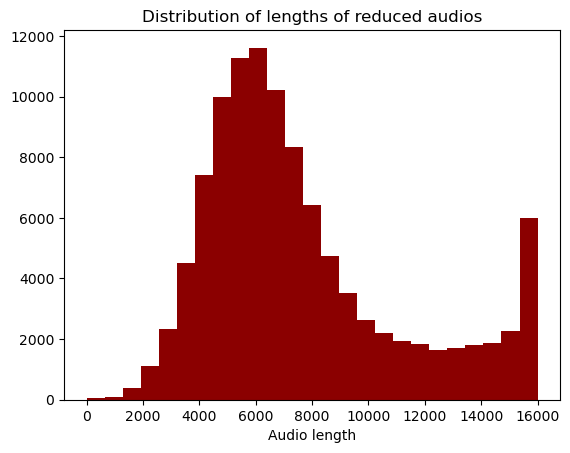

In [19]:
audio_len_array = []

for i in range(0, len(audio_labels)):
    for j in range(0, len(audio_samples[i])):
        _, data = wavfile.read(os.path.join(data_folder, audio_labels[i], audio_samples[i][j]))
        audio_len_array.append(len(data)*(16000/22050))

plt.hist(audio_len_array, bins="doane", color="darkred")
plt.title("Distribution of lengths of reduced audios")
plt.xlabel("Audio length")

Up to this point we realize that there exist an important number of files that have 16000 (1 second at 16kHz sampling frequency) as its length and it is better to pad the short files in order to get all files with a length of 16000. It is extremely important that all files have the same shape because when we build and train the neural network a fixed input shape is required. We work again with the original dataset.

For practical purposes we have decided to introduce the padding inside the **combine_audio** function which add the noise to the keyword. To show the behaviour and efficiecy of padding the responsible lines was extracted from the function and proved using specific examples that have a length less than 16000.

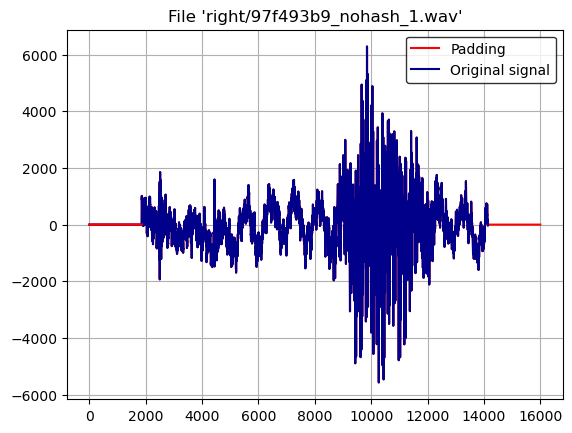

In [20]:
#ex_fil = 'no/0a396ff2_nohash_0.wav'
ex_fil = 'right/97f493b9_nohash_1.wav'
#ex_fil = 'up/4fce7686_nohash_1.wav'

ex_file = os.path.join('dataset', ex_fil)

_, wav = wavfile.read(ex_file)


padding_length = 16000 - tf.shape(wav)[0]
padding = tf.zeros(padding_length, dtype=tf.float32)
    
if padding_length % 2 == 0:
    padding1 = padding2 = padding[:padding_length // 2]
else:
    padding1 = padding[:padding_length // 2]
    padding2 = padding[(padding_length // 2):]
    
waveform = tf.concat([padding1, wav, padding2], 0)


plt.plot(waveform, color="red", label="Padding")
plt.plot(tf.concat([padding1, wav], 0), color="darkblue", label="Original signal")
plt.plot(padding1, color="red")
plt.title(f"File '{ex_fil}'" )
plt.legend(edgecolor='black')
plt.grid()

### 1.5. Background noise

In order to obtain a better performance when we train the neural network models and a more realistic approach, we must to mix the keyword with a background noise. The `_background_noise_` folder contains a set of longer audio clips that are either recordings or mathematical simulations of noise. The available noise are: 
- doing_the_dishes.wav
- dude_miaowing.wav
- exercise_bike.wav
- pink_noise.wav
- running_tap.wav
- white_noise.wav

A function was contruct for the task where we can decide if apply or not the noise and what type. Also we can decide the noise reduction. Moreover, as the clips are longer than 1 second, we randomly select a portion of them to match the size of the input.

Text(0.5, 1.0, "Example of six command: file '87070229_nohash_3.wav' WITH background noise")

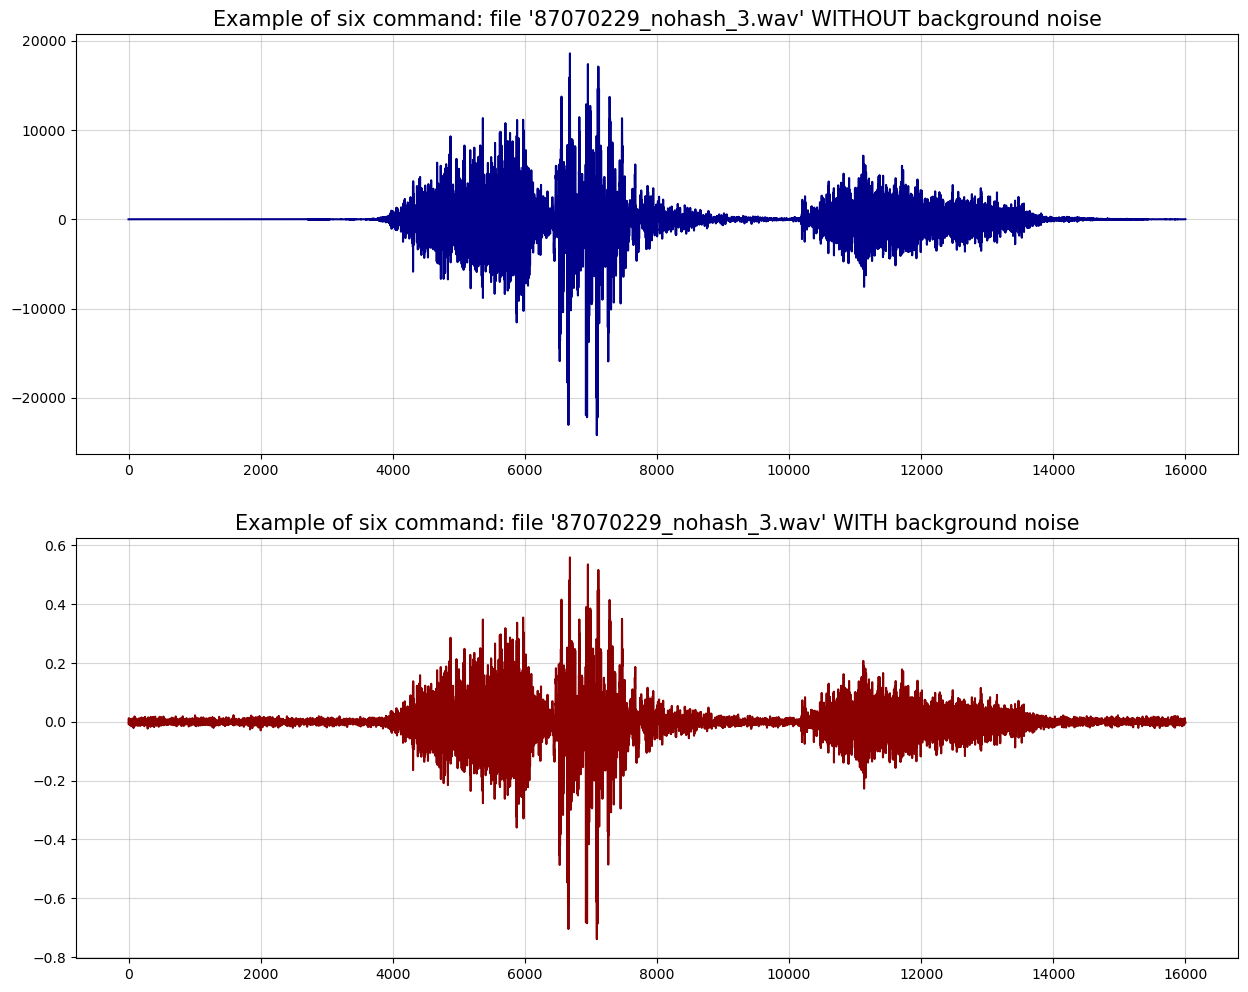

In [21]:
data_folder = "./dataset"
audio_samples, audio_labels = get_files(data_folder)

n_folder = 25
fig, ax = plt.subplots(2, figsize=(15,12))

n_file = np.random.randint(0, 1000)
path_file_ex = os.path.join(data_folder, audio_labels[n_folder], audio_samples[n_folder][n_file])

# Original wave without noise
_, data = wavfile.read(path_file_ex)
# Modified wave with noise
waveform, _, _ = combine_audio(path_file_ex, audio_labels, apply_noise=True, noise_volume_scale=0.2)

ax[0].plot(data, color='darkblue')
ax[0].grid(alpha=0.5)
ax[0].set_title("Example of {} command: file '{}' WITHOUT background noise".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=15)

ax[1].plot(waveform, color='darkred')
ax[1].grid(alpha=0.5)
ax[1].set_title("Example of {} command: file '{}' WITH background noise".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=15)

### 1.6. Extract features and preprocessing function

In the dataset the waveforms are represented in the time domain. But, to feed and to train the neural network model we need an spectrogram image which show frequency changes over time in a 2D image. Then, we have to transform the waveforms from the time-domain signals into the time-frequency-domain signals.

####    1.6.1. SFTF features

First at all, we compute the spectrogram using the widely used method which is [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) converting the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram).

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor.

Let's create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. 
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. 
- The STFT produces an array of complex numbers representing magnitude and phase. However, we will only use the magnitude, which you can derive by applying `tf.abs` on the output.

Text(83.22222222222221, 0.5, 'Features')

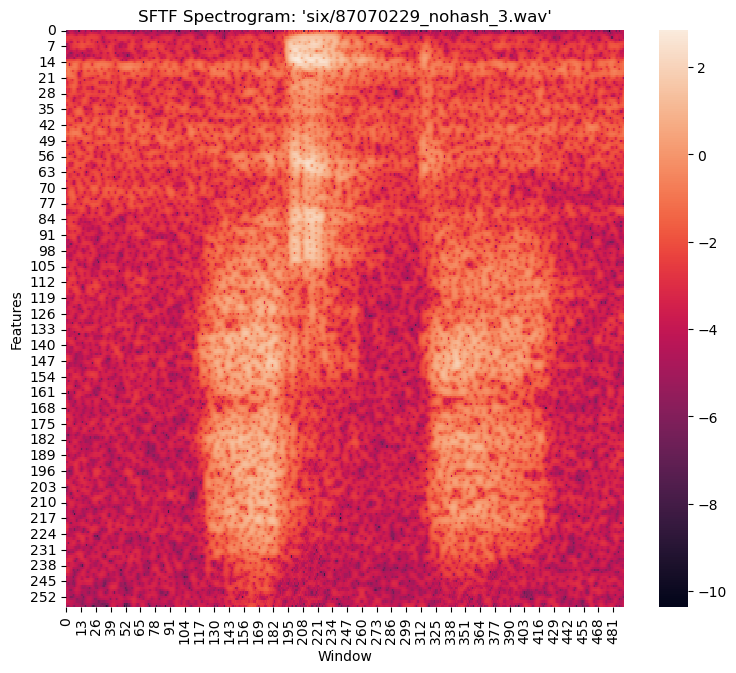

In [22]:
spec, _ = stft(waveform, audio_labels)

fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(tf.squeeze(spec))
plt.title("SFTF Spectrogram: '{}/{}'".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=12)
plt.xlabel("Window")
plt.ylabel("Features")

####    1.6.2. Mel-Filterbanks features

Text(83.22222222222221, 0.5, 'Features')

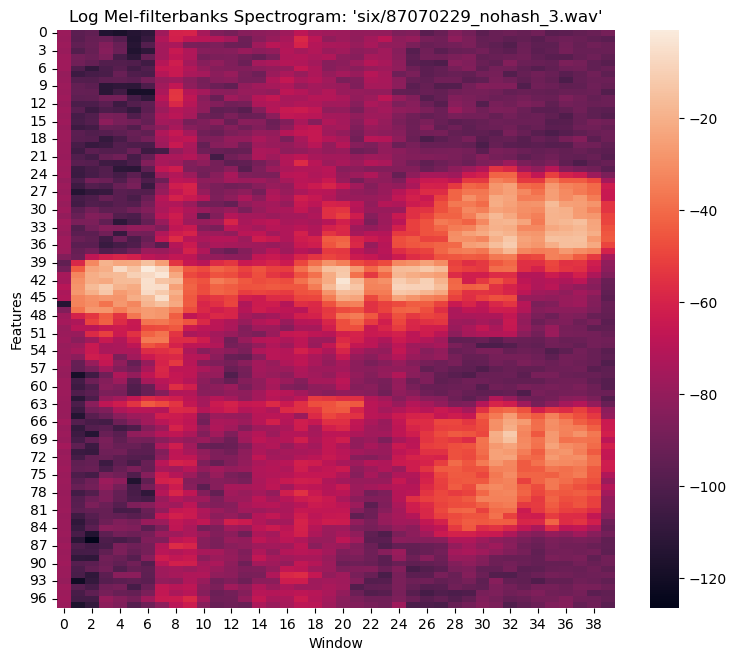

In [23]:
fb_spec, _ = filter_banks(waveform, audio_labels)

#print("Feature vector shape:", fb_spec.shape)

fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(fb_spec)
plt.title("Log Mel-filterbanks Spectrogram: '{}/{}'".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=12)
plt.xlabel("Window")
plt.ylabel("Features")

####    1.6.3. MFCC features

Text(83.22222222222221, 0.5, 'Features')

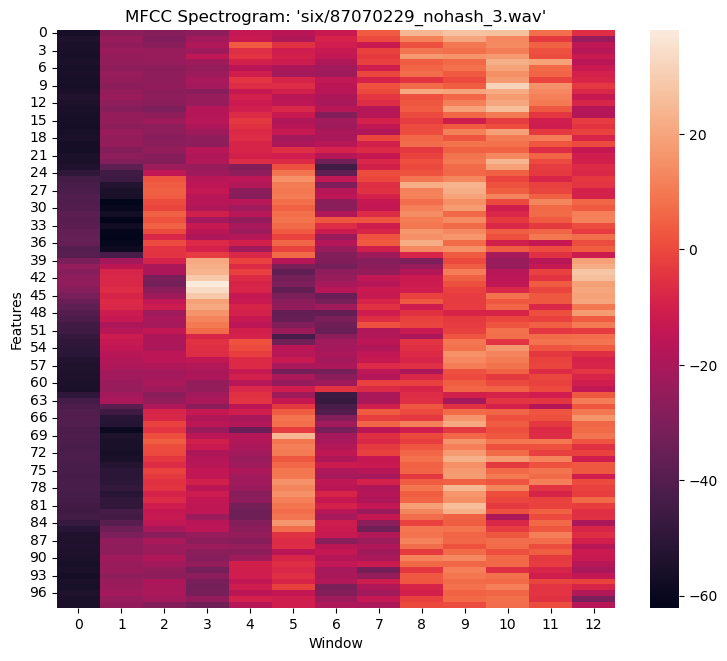

In [24]:
MFCC_spec, _, _ = MFCC(waveform, audio_labels, 67)

fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(MFCC_spec)
plt.title("MFCC Spectrogram: '{}/{}'".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=12)
plt.xlabel("Window")
plt.ylabel("Features")

####    1.6.4. DWT features

Text(83.22222222222221, 0.5, 'Features')

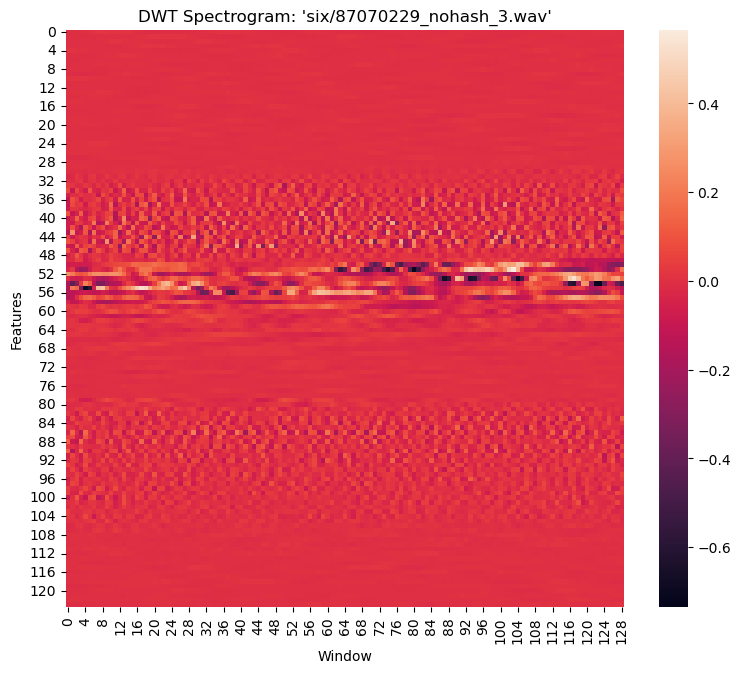

In [25]:
DWT_spec, _ = DWT(path_file_ex, audio_labels, "doing_the_dishes", True, 0.5)

fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(DWT_spec)
plt.title("DWT Spectrogram: '{}/{}'".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=12)
plt.xlabel("Window")
plt.ylabel("Features")

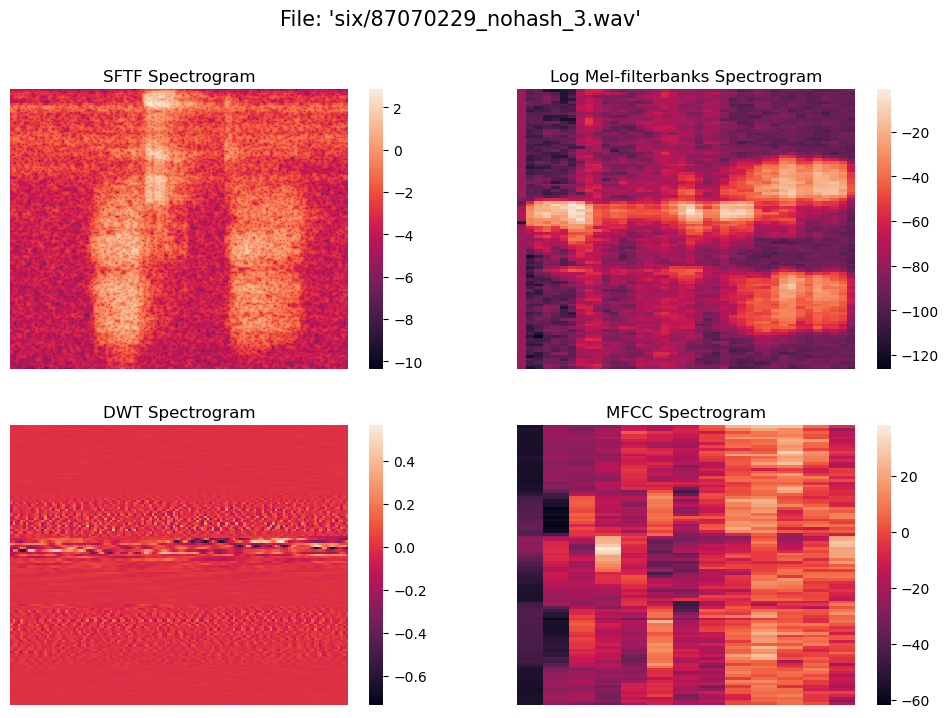

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("File: '{}/{}'".format(audio_labels[n_folder], audio_samples[n_folder][n_file]), fontsize=15)

sns.heatmap(ax=ax[0][0], data=tf.squeeze(spec))
ax[0][0].set_title("SFTF Spectrogram", fontsize=12)
#ax[0].set_xlabel("Window")
#ax[0].set_ylabel("Features")

sns.heatmap(ax=ax[0][1], data=fb_spec)
ax[0][1].set_title("Log Mel-filterbanks Spectrogram", fontsize=12)
#ax[1].set_xlabel("Window")

sns.heatmap(ax=ax[1][0], data=DWT_spec)
ax[1][0].set_title("DWT Spectrogram", fontsize=12)
#ax[2].set_xlabel("Window")

sns.heatmap(ax=ax[1][1], data=MFCC_spec)
ax[1][1].set_title("MFCC Spectrogram", fontsize=12)
#ax[2].set_xlabel("Window")

for i in range(2):
    for j in range(2):
        ax[i][j].set(xticklabels=[])  
        ax[i][j].tick_params(bottom=False)  
        ax[i][j].set(yticklabels=[])  
        ax[i][j].tick_params(left=False) 

In [ ]:
data_folder = "./dataset"
audio_samples, audio_labels = get_files(data_folder)

In [ ]:
all_data_array = []

for i in range(0, 35):
    for j in audio_samples[i]:
        path = os.path.join(data_folder, audio_labels[i], j)
        #_, data = wavfile.read(path)
        complete_data, _, _ = combine_audio(path, audio_labels, apply_noise=False)
        all_data_array.append(complete_data)

In [ ]:
import pandas as pd

al_data_df = pd.DataFrame(all_data_array)